# Network Connectivity:  Community Detection - code along

## Introduction
In previous lessons, we looked at properties of individual nodes in a network. In this lesson, we will work with larger chunks of the network, analyzing not just the individuals nodes and connections, but subgraphs and    groups of nodes, and how these groups are related to each other. There are a number of approaches and algorithms which may help us achieve that. We shall focus on a couple of important algorithms that we will put in practice with suitable use cases. 

## Objectives

You will be able to: 

- Understand and explain the role of community detection techniques in network analysis
- Describe what graph components, subgraphs and connected graphs are
- Explain and implement Girvan Newman Algorithm for community detection
- Explain and implement k-Cliques Algorithm for community detection

## Community Detection
Real world networks often have community structure. It is characteristic that the groups of nodes are connected denser within themselves and rarely with each other.

>Communities (also called partitions, clusters, groupings) in networks are sets of nodes that are more densely connected within a community than between other communities. Community detection aims to reveal underlying community structure and can be handled in several different ways.

<img src ="comm1.png" width=200>

In the study of complex networks, a network is said to have community structure if the nodes of the network can be easily grouped into (potentially overlapping) sets of nodes such that each set of nodes is densely connected internally. In the particular case of non-overlapping community finding, this implies that the network divides naturally into groups of nodes with dense connections internally and sparser connections between groups. But overlapping communities are also allowed. The more general definition is based on the principle that pairs of nodes are more likely to be connected if they are both members of the same community(ies), and less likely to be connected if they do not share communities.

<img src ="cd1.png" width=600>

Let's see some definitions around this concept before looking at community detection algorithms. 

### Subgraphs
A **subgraph** of $G$ is a graph whose nodes and edges are all in $G$. An **induced subgraph** $G[U]$ is a subgraph defined by a subset of nodes $U \subseteq V(G)$ with all the edges in $G$ that link nodes in $U$. A subgraph is **maximal** in respect to some property if the addition of more nodes to the subgraph will cause the loss of that property.

![](sub.gif)
### Connected components
For undirected graphs, a **component** is a maximal connected subgraph, which means that there is at least one path between any two nodes in that subgraph.

For directed graphs, a **weakly connected component** is a subgraph that is connected if we replace all of its directed edges with undirected edges. A **strongly connected component** is a subgraph where there is a path in each direction between each pair of nodes of the subgraph.

![](comps.png)

You can check NetworkX documentation for the functions that deal with [components](http://networkx.readthedocs.io/en/latest/reference/algorithms.component.html).

Ler's create two subgraphs as a part of a single graph and keep them disjoint:

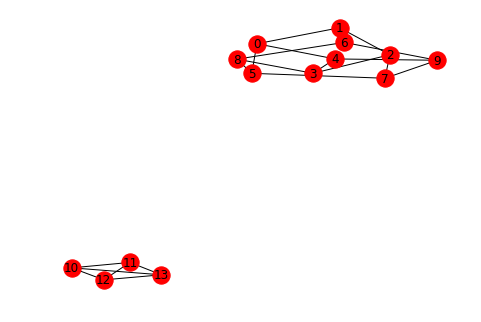

In [3]:
import networkx as nx

G = nx.disjoint_union(nx.petersen_graph(), nx.tetrahedral_graph())
nx.draw(G, with_labels=True)

The function `nx.connected_components` extracts the groups of nodes (components of a graph) that are connected more tightly to each other, than to other parts of the graph  If you want the induced subgraphs of the components you have to use `nx.connected_component_subgraphs` as we shall see below:

Let's see the connected components from graph above:

list(nx.connected_components(G))

We can also check the size and and identify the largest component by taking the maximum of all components:

In [4]:
largest = max(nx.connected_components(G), key=len)
len(largest), largest

(10, {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

For directed graphs we have to distinguish between weakly and strongly connected components as shown above:

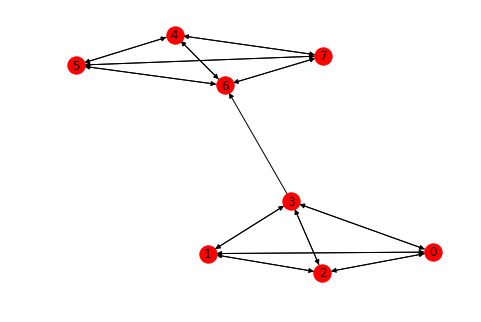

In [6]:
D = nx.disjoint_union(nx.tetrahedral_graph(create_using=nx.DiGraph()), 
                      nx.tetrahedral_graph(create_using=nx.DiGraph()))

D.add_edge(3, 6)
nx.draw(D, with_labels=True)

using `nx.weakly_connected_components()` and `nx.strongly_connected_components()` methods, we can highlight the subgroups of a larger directed graph that may be weakly or strongly connected:

In [7]:
list(nx.weakly_connected_components(D))

[{0, 1, 2, 3, 4, 5, 6, 7}]

In [8]:
list(nx.strongly_connected_components(D))

[{4, 5, 6, 7}, {0, 1, 2, 3}]

## Girvan Newman Algorithm
> The Girvan–Newman algorithm detects communities by progressively removing edges from the original graph. The algorithm removes the “most valuable” edge, traditionally the edge with the highest betweenness centrality, at each step. As the graph breaks down into pieces, the tightly knit community structure is exposed.

 [Here is a great poster](https://scholarexchange.furman.edu/cgi/viewcontent.cgi?article=1527&context=furmanengaged) summarizing how this algorithm works. The algorithm's steps for community detection are summarized below

- The betweenness of all existing edges in the network is calculated first.
- The edge with the highest betweenness is removed.
- The betweenness of all edges affected by the removal is recalculated.
- Steps 2 and 3 are repeated until no edges remain.

![](gn.jpg)

Networkx comes packaged with an implementation of this algorithm and here is how it works:

> Iterator over tuples of sets of nodes in G. Each set of nodes is a community, each tuple is a sequence of communities at a particular level of the algorithm.

Read a bit more into this algorithm [Here](https://en.wikipedia.org/wiki/Girvan%E2%80%93Newman_algorithm). Let's see this in practice:

In [9]:
from networkx.algorithms.community import girvan_newman
GA = nx.read_gexf('ga_graph.gexf')
community = girvan_newman(GA)
comm_iter1 = tuple(sorted(c) for c in next(community))
dict(enumerate(comm_iter1))

{0: ['addison',
  'arizona',
  'avery',
  'denny',
  'derek',
  'finn',
  'grey',
  'hank',
  'izzie',
  'karev',
  'kepner',
  'lexi',
  'mrs. seabury',
  'nancy',
  "o'malley",
  'olivia',
  'sloan',
  'steve',
  'torres'],
 1: ['altman', 'colin', 'owen', 'preston', 'yang'],
 2: ['adele', 'chief', 'ellis grey', 'susan grey', 'thatch grey'],
 3: ['bailey', 'ben', 'tucker']}

So for the undirected Grey's anatomy graph, the GN algorithm identifies four possible communities as shown above. Let's try to visualize these. Let's first add a new node attribute to the graph to reflect which community (0-3) it belongs to:

In [10]:
# Create a community map and assign community as a node attribute
comm1 = community
community_map = {}

for node in GA.nodes():
    for i, comm1 in enumerate(comm_iter1):
        if node in comm1:
            community_map[node] = i
    if community_map.get(node, None) is None:
        community_map[node] = None

for k, v in community_map.items():
    GA.node[k]['community'] = v

community_map

{'lexi': 0,
 'sloan': 0,
 'karev': 0,
 'owen': 1,
 'yang': 1,
 'altman': 1,
 'torres': 0,
 'arizona': 0,
 'derek': 0,
 'grey': 0,
 'izzie': 0,
 "o'malley": 0,
 'colin': 1,
 'preston': 1,
 'kepner': 0,
 'addison': 0,
 'nancy': 0,
 'olivia': 0,
 'mrs. seabury': 0,
 'chief': 2,
 'adele': 2,
 'ellis grey': 2,
 'thatch grey': 2,
 'susan grey': 2,
 'bailey': 3,
 'tucker': 3,
 'hank': 0,
 'denny': 0,
 'finn': 0,
 'steve': 0,
 'ben': 3,
 'avery': 0}

Great, now let's import the library we used earlier for color coding the nodes and use it to assign a color to each community nodes. Remember for our examples, we are dealing with simple networks with <5 communities. In larger networks, there may be hundreds of communities present to color coding nodes may become complicated. The functions below takes in the graph and according to the number of classes in the attribute that we pass in, it automatically generates a color map having a color for each class/group/community. 

In [11]:
# The color coding function

from seaborn import color_palette, set_style, palplot

def create_color_map(G, attribute, seaborn_palette="colorblind"):

    attr = [G.node[label][attribute] for label in G.nodes()]
    # get the set of possible attributes
    attr_uniq = list(set(attr))
    vals = len(attr_uniq)
    # generate color palette from seaborn
    palette = color_palette(seaborn_palette, vals).as_hex()
    # create a mapping of attribute to color
    cmap = dict(zip(attr_uniq, palette))
    # map the attribute for each node to the color it represents
    colors = [cmap[attr] for attr in attr]

    return colors, cmap, palette

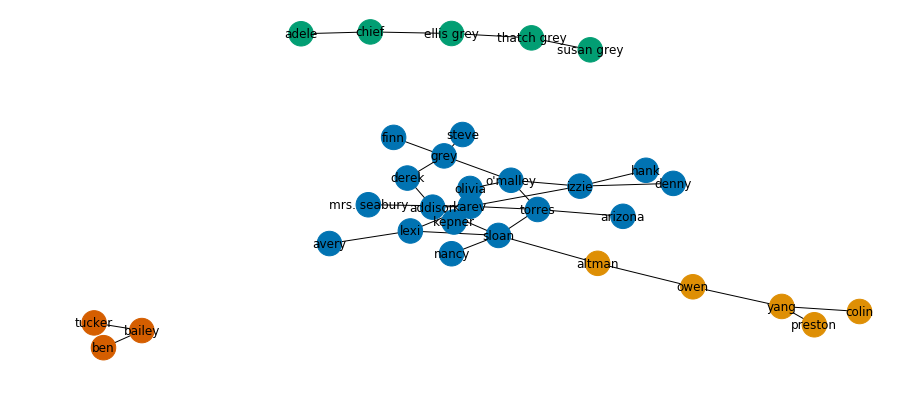

In [12]:
# Draw the color coded graph 
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
node_colors, color_map, palette = create_color_map(GA, 'community')
nx.draw(GA, node_size = 600, node_color=node_colors, with_labels=True)

Right, so we see four comuunities in the first iteration. Let's have another go and see how the community structure changes in the second iteration. Let's identify deeper communities and save it as attribute `community2`:

In [13]:
# The 2nd Iteration
comm_iter2 = tuple(sorted(c) for c in next(community))
comm2 = community

community_map2 = {}
for node in GA.nodes():
    for i, comm2 in enumerate(comm_iter2):
        if node in comm2:
            community_map2[node] = i
    if community_map2.get(node, None) is None:
        community_map2[node] = None

for k, v in community_map2.items():
    GA.node[k]['community2'] = v

community_map2

{'lexi': 0,
 'sloan': 0,
 'karev': 0,
 'owen': 1,
 'yang': 1,
 'altman': 1,
 'torres': 0,
 'arizona': 0,
 'derek': 2,
 'grey': 2,
 'izzie': 0,
 "o'malley": 0,
 'colin': 1,
 'preston': 1,
 'kepner': 0,
 'addison': 0,
 'nancy': 0,
 'olivia': 0,
 'mrs. seabury': 0,
 'chief': 3,
 'adele': 3,
 'ellis grey': 3,
 'thatch grey': 3,
 'susan grey': 3,
 'bailey': 4,
 'tucker': 4,
 'hank': 0,
 'denny': 0,
 'finn': 2,
 'steve': 2,
 'ben': 4,
 'avery': 0}

Draw the graph with 2nd iteration community detection:

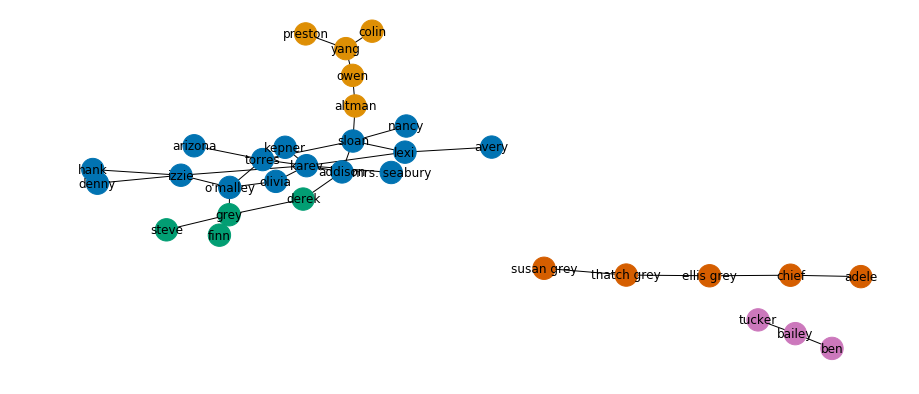

In [14]:
node_colors, color_map, palette = create_color_map(GA, 'community2')
plt.figure(figsize=(12, 5))

nx.draw(GA, node_size=500, node_color=node_colors, with_labels=True)

## K-Clique Communities

> a __clique__ is a subset of vertices of an undirected graph such that its induced subgraph is complete; that is, every two distinct vertices in the clique are adjacent. 

A __k-clique community__ is the union of all cliques of size k that can be reached through adjacent (sharing k-1 nodes) k-cliques.

![cliques](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d0/VR_complex.svg/500px-VR_complex.svg.png)
A graph with
- 23 × 1-vertex cliques (the vertices),
- 42 × 2-vertex cliques (the edges),
- 19 × 3-vertex cliques (light and dark blue triangles), and
- 2 × 4-vertex cliques (dark blue areas).

[Visit here](http://www.cs.ecu.edu/karl/6420/spr16/Notes/NPcomplete/clique.html) to read more on __Clique problem__.  Following function calculates cliques in networkx:

```
k_clique_communities(G, k, cliques=None)[source]
Find k-clique communities in graph using the percolation method.

A k-clique community is the union of all cliques of size k that can be reached through adjacent (sharing k-1 nodes) k-cliques.

Parameters:	
G (NetworkX graph) –
k (int) – Size of smallest clique
cliques (list or generator) – Precomputed cliques (use networkx.find_cliques(G))
Returns:	
Return type:	
Yields sets of nodes, one for each k-clique community.

```

Let's use this with our GA dataset as shown below:

In [15]:
from networkx.algorithms.community import k_clique_communities

k_clique = k_clique_communities(GA, 2)
dict(enumerate(k_clique))

{0: frozenset({'adele', 'chief', 'ellis grey', 'susan grey', 'thatch grey'}),
 1: frozenset({'addison',
            'altman',
            'arizona',
            'avery',
            'colin',
            'denny',
            'derek',
            'finn',
            'grey',
            'hank',
            'izzie',
            'karev',
            'kepner',
            'lexi',
            'mrs. seabury',
            'nancy',
            "o'malley",
            'olivia',
            'owen',
            'preston',
            'sloan',
            'steve',
            'torres',
            'yang'}),
 2: frozenset({'bailey', 'ben', 'tucker'})}

Let's try k=3:

In [16]:
k_clique = k_clique_communities(GA, 3)
dict(enumerate(k_clique))

{}

i.e. we cant create communities in the graph where the size of smallest clique is 3. 

So there we have it. We have looked into two popular ways for identifying communities in a graph. There are other ways including k-cores, Clustering approaches etc. that you can consider when working with community detection. 

## Level-up (Optional)

- Take the communities detected by the Cliques approach and visualize them using the function shown above. 

## Additional Resources 

- https://arxiv.org/abs/1608.00163
- https://www.researchgate.net/figure/k-cliques-examples_fig2_225150765

## Summary 

In this lesson, we looked at community detection using two popular algorithms, namely Girvan Newman and k-Cliques communities. We also looked at the visualizing the induced communities. You are encourages to take some time out and read the additional documents provided above to see more examples of this in action. 